In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pylab as plt

from sigvisa import Sigvisa
from sigvisa.treegp.gp import GP, GPCov
%aimport sigvisa.models.spatial_regression.local_gp_ensemble 

lge = sigvisa.models.spatial_regression.local_gp_ensemble 



import sklearn.cluster

In [10]:
s = Sigvisa()
cursor = s.dbconn.cursor()
cursor.execute("select lon, lat, depth, mb from isc_origin where mb > 0")
V = np.array(cursor.fetchall())
cursor.close()
X = V[:, :3].copy()
y = V[:, 3].copy()

In [3]:
n = len(X)
target_size = 100
n_clusters = (n / target_size) * 2

depth_scale = 100.0
X_euclidean = X.copy()
X_euclidean[:, 2] /= depth_scale

km = sklearn.cluster.KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, 
                            max_iter=300, tol=0.0001, precompute_distances='auto', 
                            verbose=0, random_state=None, copy_x=True, n_jobs=1)
r = km.fit(X_euclidean)

assignments = r.predict(X_euclidean)
print "%d clusters of sizes %s" % (n_clusters, [np.sum(assignments==i) for i in range(n_clusters)])

46 clusters of sizes [373, 60, 239, 41, 28, 70, 69, 5, 24, 31, 27, 25, 18, 6, 69, 40, 70, 30, 24, 118, 65, 47, 27, 14, 53, 35, 78, 113, 56, 18, 14, 7, 22, 79, 33, 13, 5, 46, 33, 27, 16, 4, 27, 71, 22, 27]


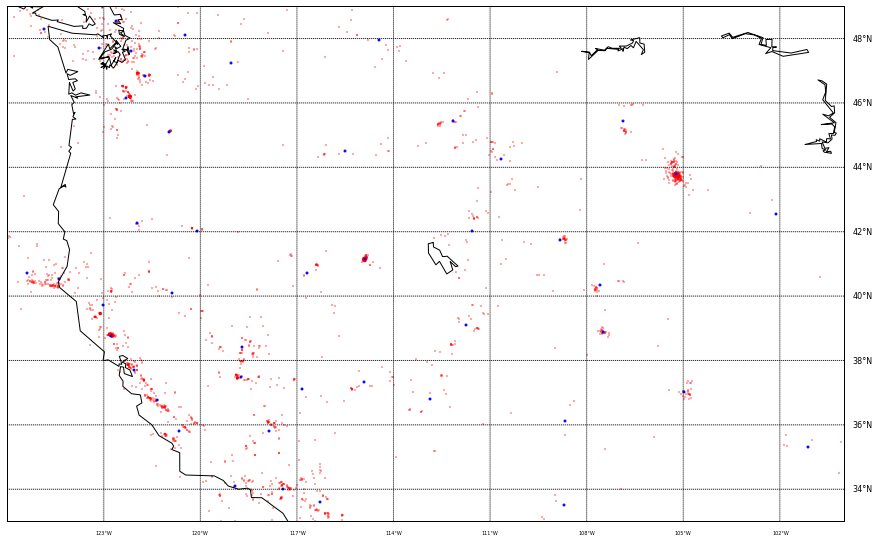

In [4]:
from sigvisa.plotting.event_heatmap import EventHeatmap

hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=False)

f = plt.figure(figsize=(15, 15))
ax = plt.gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth()

normed_locations = np.array([hm.normalize_lonlat(*x[:2]) for x in X ])
scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], alpha=0.3, s=6, marker=".", color="red")

normed_centers= np.array([hm.normalize_lonlat(*x[:2]) for x in r.cluster_centers_ ])
scplot = hm.bmap.scatter(normed_centers[:, 0], normed_centers[:, 1], alpha=1.0, s=15, marker=".", color="blue")

In [66]:
cluster_centers = r.cluster_centers_.copy()
cluster_centers[:, 2] *= depth_scale

basic_cov = GPCov(wfn_str="matern32", wfn_params=(1.0,), dfn_str="lld", dfn_params=(30.0, 30.0))
cluster_covs = [basic_cov.copy() for i in range(n_clusters)]

cluster_noise_vars = [1.0 for i in range(n_clusters)]



In [102]:
lgp = lge.LocalGPEnsemble(X, y, 
                          cluster_centers=cluster_centers, 
                          cluster_covs = cluster_covs,
                          cluster_noise_vars = cluster_noise_vars)

In [103]:
X1 = X[0:1, :]

print X1
print y[0]
print lgp.predict(X1)
print lgp.variance(X1, include_obs=False)

[[-105.2442   43.5355    0.    ]]
2.5
3.22785267023
[ 0.08234593]


In [104]:
idx = lgp._x_to_cluster(X1)
print idx
llgp = lgp.local_gps[idx]
print llgp.X[8, :]
print llgp.y[8]

[0]
[[-105.2442   43.5355    0.    ]]
2.5


In [105]:
print lgp._compute_marginal_likelihood()
gg = lgp._log_likelihood_gradient()
g0 = lgp.local_gps[0].ll_grad
print g0
print gg[:4]

-3467.86482861
[ -1.27873733e+02   1.09566122e+01   1.04201072e+00   6.64621220e-04]
[ -1.27873733e+02   1.09566122e+01   1.04201072e+00   6.64621220e-04]


In [115]:
params = np.array(lgp.get_flat_params())


In [116]:

def llparams(params4):
    nparams = params.copy()
    nparams[:4] = params4
    covs, nvs = lgp.unflatten_to_covs(nparams)
    lgpn = lge.LocalGPEnsemble(X, y, 
                               cluster_centers=cluster_centers, 
                               cluster_covs = covs,
                               cluster_noise_vars = nvs)
    return lgpn._compute_marginal_likelihood()

print llparams(params[:4])

-3467.86482861


In [117]:
import scipy.optimize
x0 = np.array(params[:4]).copy()
gn = scipy.optimize.approx_fprime(x0, llparams, 1e-4)